In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

sns.set_context("talk")
sns.set_style("white")

In [2]:
train = pd.read_csv('Data/3.6/train.csv')
test = pd.read_csv('Data/3.6/test.csv')
sub = pd.read_csv('Data/3.6/sample_submission.csv')
extra = pd.read_csv('Data/3.6/ParisHousing.xls')

train.drop(columns=['id','cityCode'], inplace=True)
test.drop(columns=['id','cityCode'], inplace=True)
extra.drop(columns=['cityCode'], inplace=True)

# Missing Values

In [3]:
train.isnull().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

In [4]:
extra.isnull().sum()

squareMeters         0
numberOfRooms        0
hasYard              0
hasPool              0
floors               0
cityPartRange        0
numPrevOwners        0
made                 0
isNewBuilt           0
hasStormProtector    0
basement             0
attic                0
garage               0
hasStorageRoom       0
hasGuestRoom         0
price                0
dtype: int64

In [5]:
df = pd.concat([train,extra])

# Plots

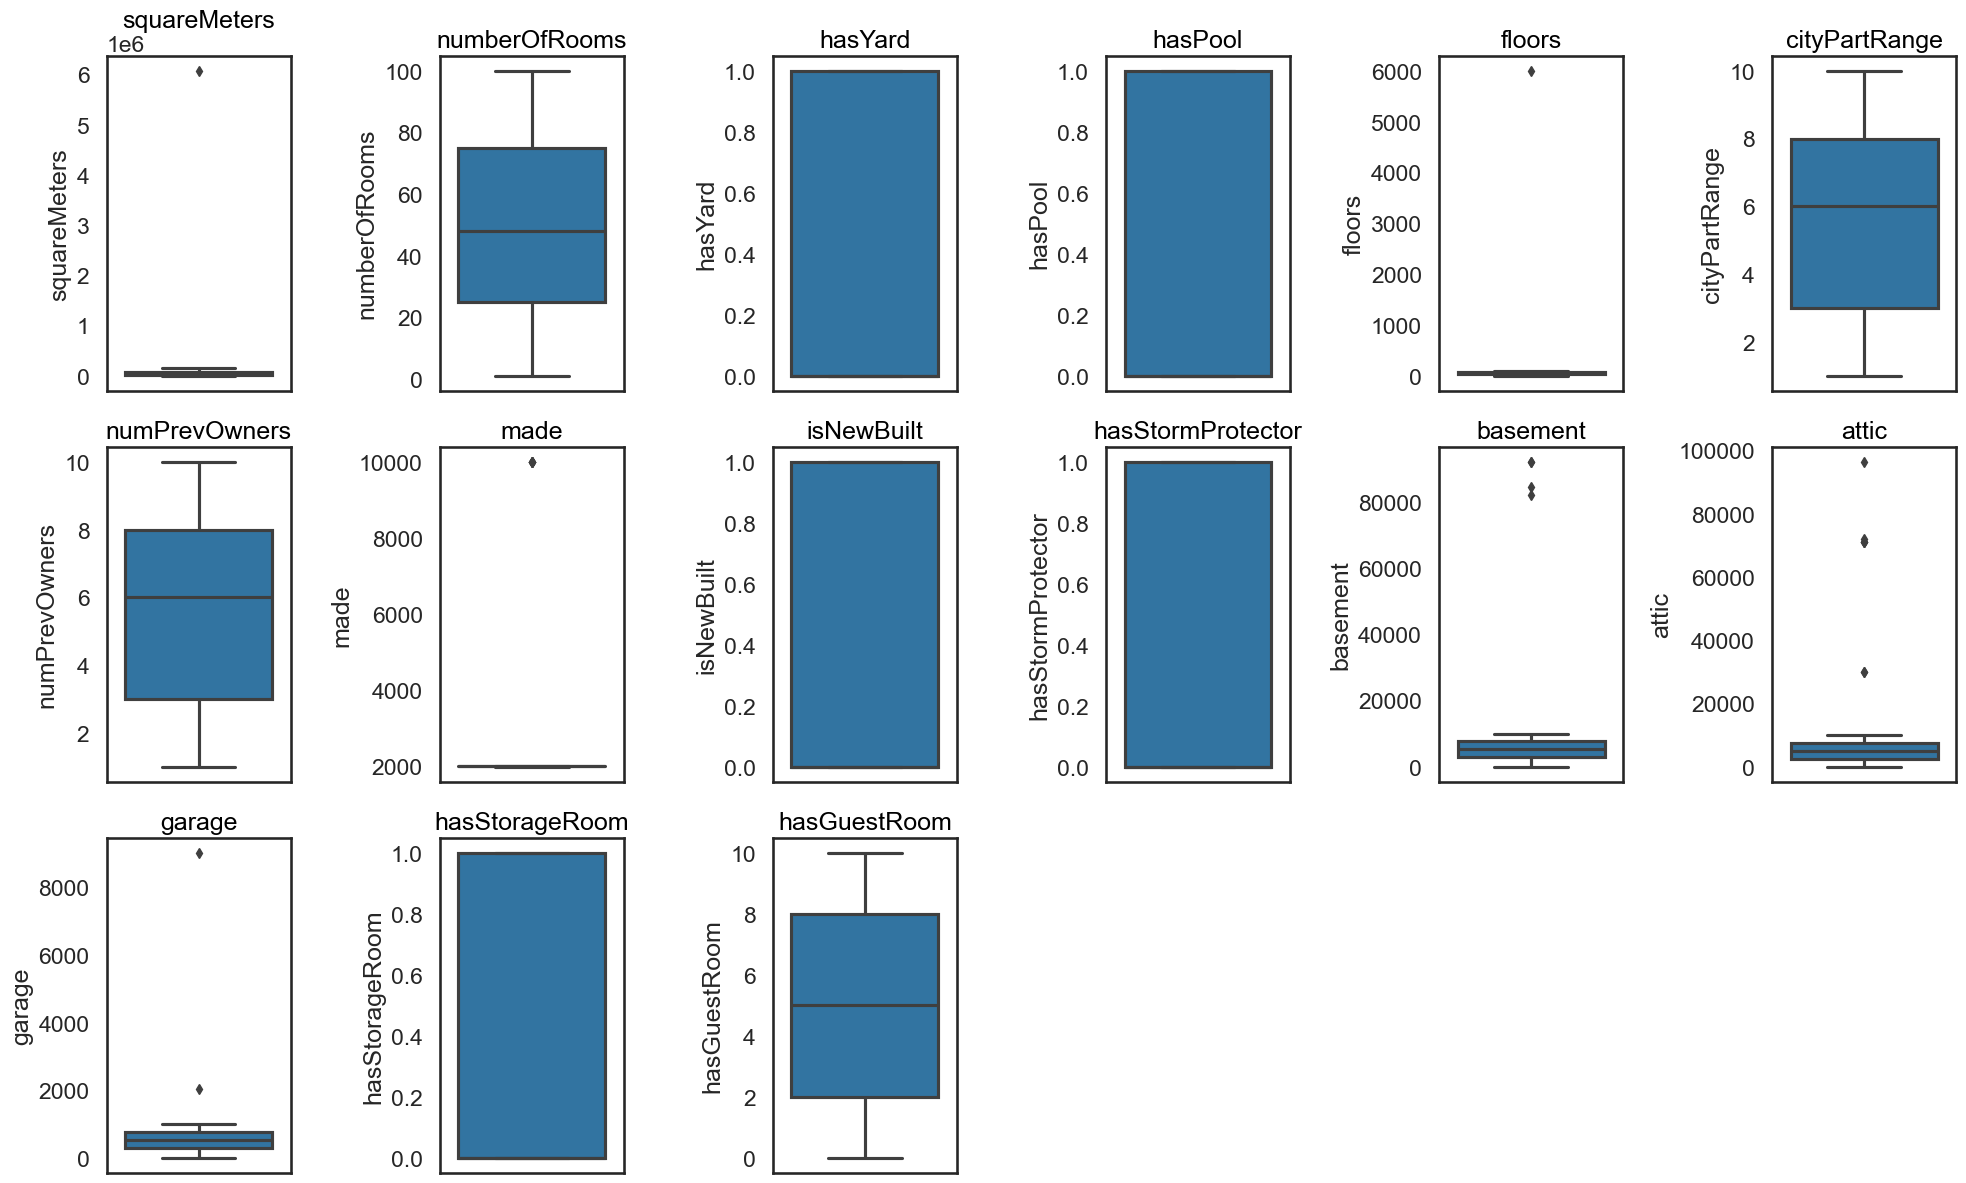

In [6]:
num_cols = test.columns.to_list()

def box_plot(dataframe, features, rows, cols): 
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        sns.boxplot(y=dataframe[feature],data=train)
        ax.set_title(feature,color='black')
    fig.tight_layout()  
    plt.show()

box_plot(df,num_cols,5,6)

In [7]:
df = df[df['squareMeters'] < 6071330.0]
df = df[df['floors'] < 2000]
df = df[df['garage'] < 2000]
df = df[df['made'] < 2000]
df = df[df['basement'] < 60000]
df = df[df['attic'] < 20000]

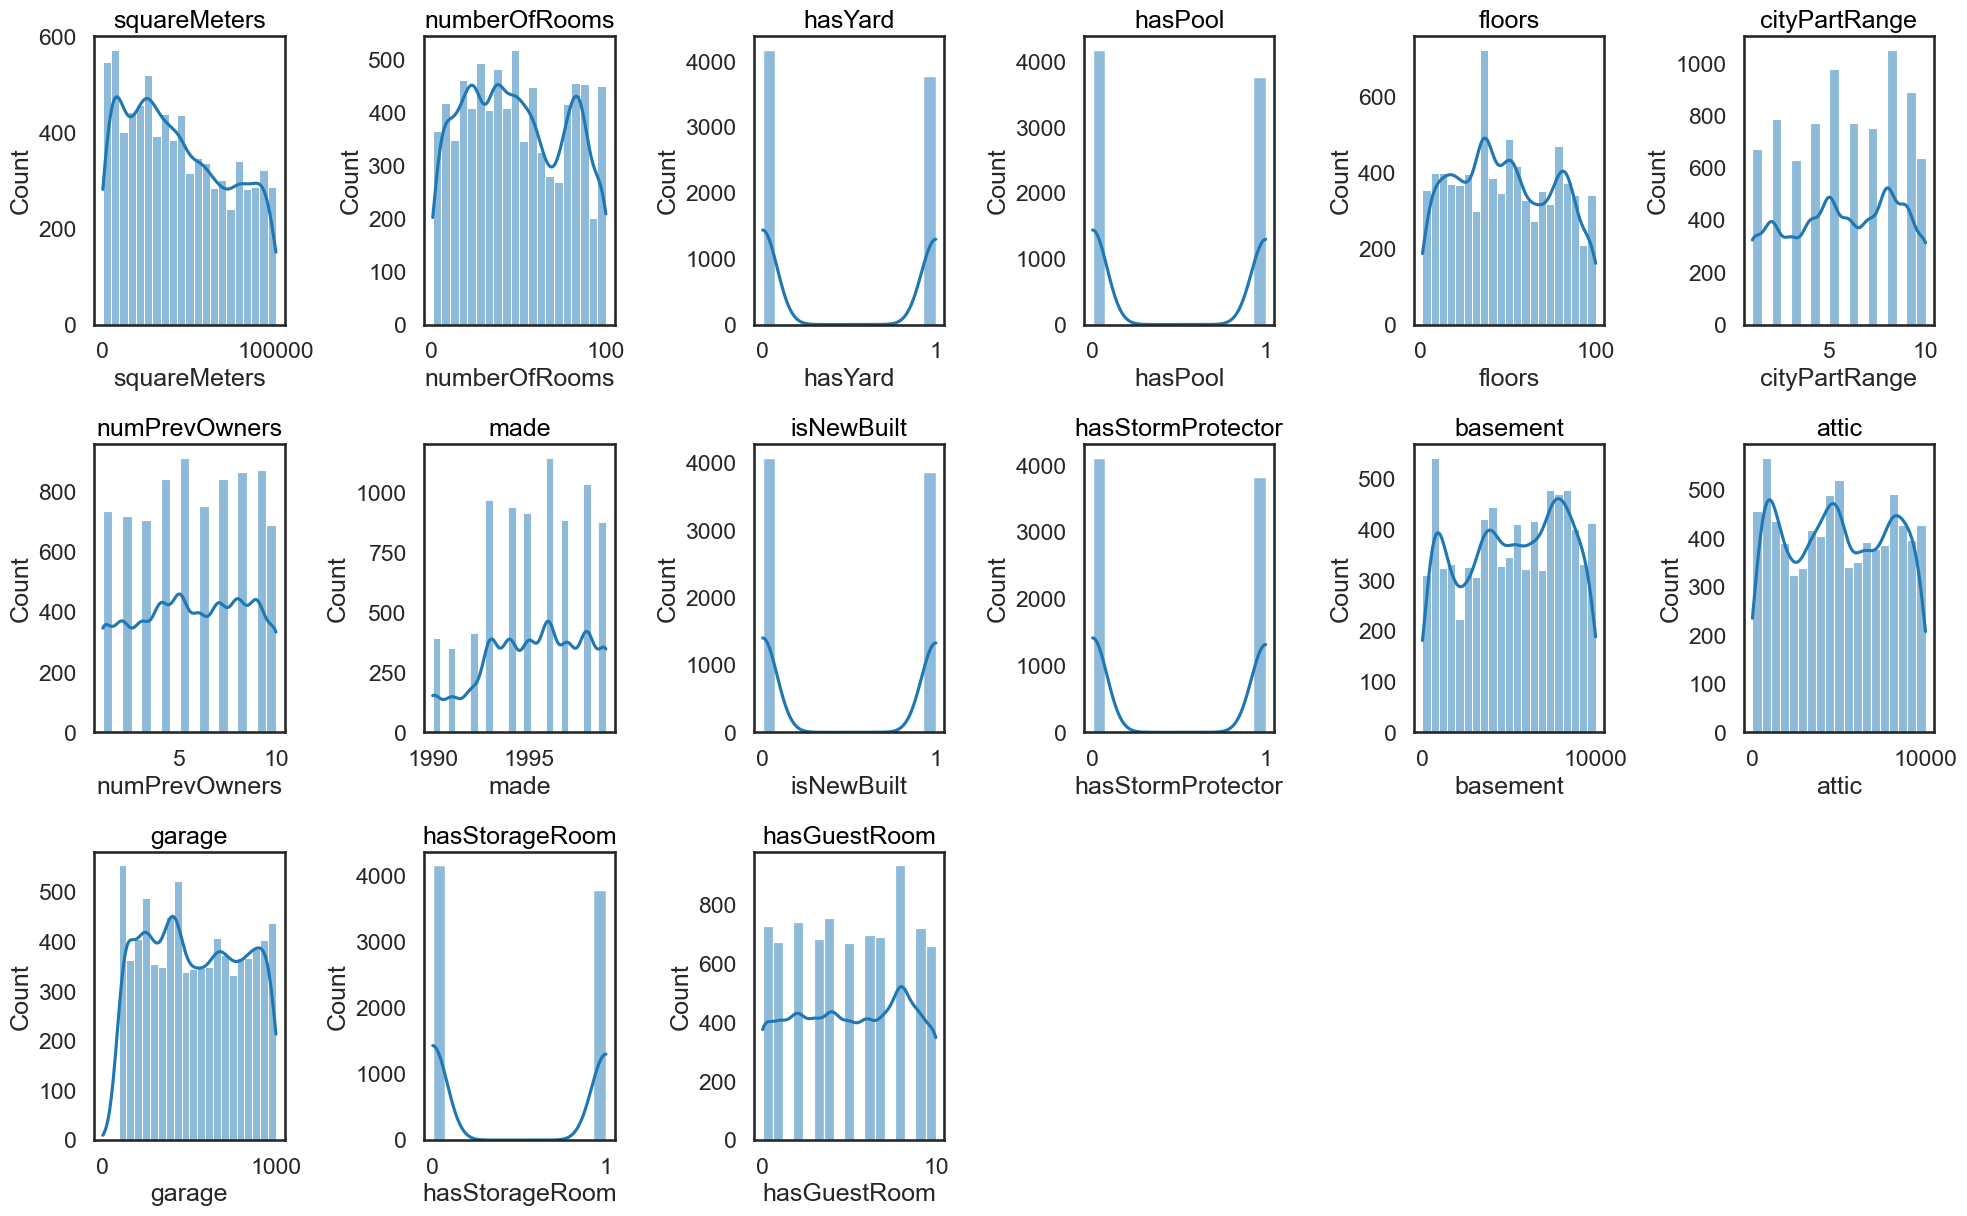

In [8]:
def hist_plot(dataframe, features, rows, cols): 
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        sns.histplot(x=dataframe[feature], fill=True, data=train, kde=True)
        ax.set_title(feature,color='black')
    fig.tight_layout()  
    plt.show()

hist_plot(df,num_cols,5,6)

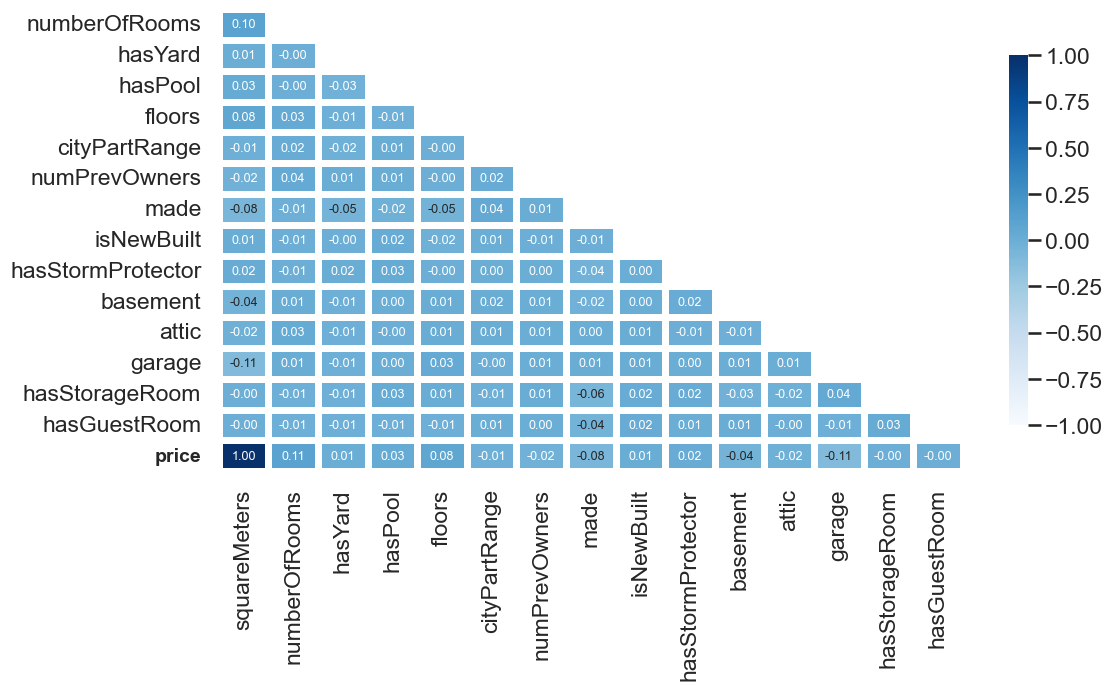

In [9]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(12, 6))
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, fmt=".2f", cmap='Blues',vmin=-1, vmax=1, annot=True, annot_kws={'fontsize': 9}, cbar_kws={"shrink": .8}, linewidths=5,)
plt.yticks(rotation=0)
plt.yticks()[-1][-1].set_fontsize(14)
plt.yticks()[-1][-1].set_fontweight('bold')
plt.show()

# Model

In [10]:
std_ = StandardScaler()
mms_ = MinMaxScaler()
mas_ = MaxAbsScaler()
rbs_ = RobustScaler()
nml_ = Normalizer ()

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_std = std_.fit_transform(X)
X_mms = mms_.fit_transform(X)
X_mas = mas_.fit_transform(X)
X_rbs = rbs_.fit_transform(X)
X_nml = nml_.fit_transform(X)

df_result = pd.DataFrame(columns=['model','scale','mse'])

xgb = XGBRegressor()

def train_test(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.7,random_state=2023)
    return x_train, x_test, y_train, y_test

def train_model(x,y, model,n_model, scale):
    x_train, x_test, y_train, y_test = train_test(x,y)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    new_ = {'model':str(n_model),'scale':scale,'mse':mse(pred, y_test)}
    return new_, model

In [11]:
dic ,model_std = train_model(X_std,y,xgb,'XGBRegressor','StandardScaler')
df_result = df_result.append(dic, ignore_index=True)

dic ,model_mms = train_model(X_mms,y,xgb,'XGBRegressor','MinMaxScaler')
df_result = df_result.append(dic, ignore_index=True)

dic ,model_mas = train_model(X_mas,y,xgb,'XGBRegressor','MaxAbsScaler')
df_result = df_result.append(dic, ignore_index=True)

dic ,model_rbs = train_model(X_rbs,y,xgb,'XGBRegressor','RobustScaler')
df_result = df_result.append(dic, ignore_index=True)

dic ,model_nml = train_model(X_nml,y,xgb,'XGBRegressor','Normalizer')
df_result = df_result.append(dic, ignore_index=True)

In [12]:
df_result

,model,scale,mse
0,XGBRegressor,StandardScaler,3.105943e+08
1,XGBRegressor,MinMaxScaler,3.107212e+08
2,XGBRegressor,MaxAbsScaler,3.109316e+08
3,XGBRegressor,RobustScaler,3.106479e+08
4,XGBRegressor,Normalizer,8.963533e+08


In [13]:
X_test = nml_.fit_transform(test)
sub['pice'] = model_nml.predict(X_test)